<h1>Neural Networks</h1>
<h4>Implementing the backpropagation algorithm for neural networks and applying it to recognize hand written digits</h4>

In [1]:
import numpy as np 
import scipy.optimize as opt 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.io import loadmat 


<h3>Importing and reading the data</h3>

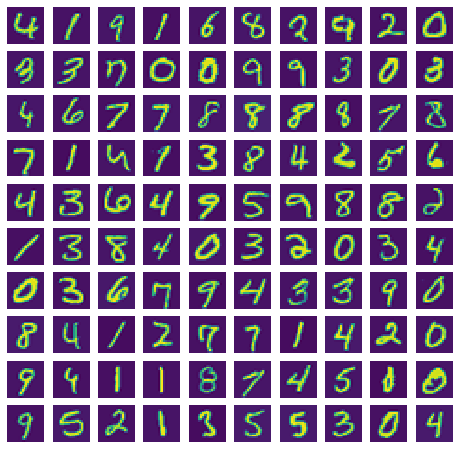

In [2]:
data = loadmat("Datasets/ex4data1.mat")
X = data['X']
y = data['y']

import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"))
        
        axis[i,j].axis("off")

In [3]:
weights = loadmat('Datasets/ex4weights.mat')
theta1 = weights['Theta1'] # 25 x 401
theta2 = weights['Theta2'] # 10 x 26

#unroll parameters
params = np.hstack((theta1.ravel(order='F'),theta2.ravel(order="F")))
print(params)

#neural network hyperparameters
inputLayer = 400
hiddenLayer = 25
outputLayer = 10
lmbda = 1

[-0.02256239 -0.09838113  0.11615605 ... -2.11014003 -2.1319153
 -1.32752042]


<h3>Implementing the cost function</h3>

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

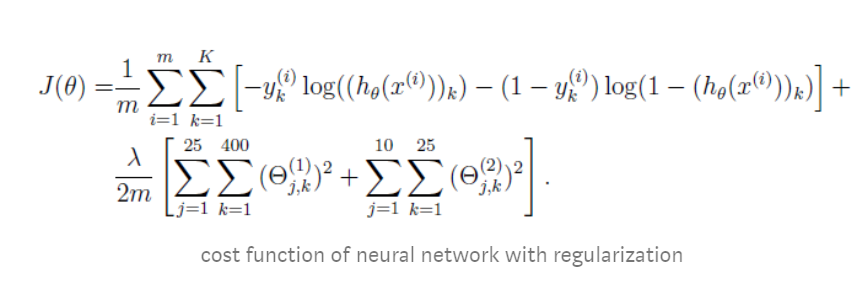

In [5]:
from IPython.display import Image
Image(filename="Datasets/costfunction.png")

In [6]:
def costfunction(params, inputlayer, hiddenlayer, outputlayer, X, y, lmbda):
    theta1 = np.reshape(params[:hiddenlayer*(inputlayer+1)], (hiddenlayer, inputlayer+1), 'F')
    theta2 = np.reshape(params[hiddenlayer*(inputlayer+1):], (outputlayer, hiddenlayer+1), 'F')
    
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones,X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones,a2))
    h = sigmoid(a2 @ theta2.T)
   
    #get_dummies gets one hot encoding from the pandas library
    ynew = pd.get_dummies(y.flatten())
    
    temp1 = np.multiply(ynew, np.log(h))
    temp2 = np.multiply(1-ynew, np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    temp4 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    temp5 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (temp4 + temp5) * lmbda / (2*m)

In [7]:
cost = costfunction(params, inputLayer, hiddenLayer, outputLayer, X, y, lmbda)
print('Cost at parameters(Regularized): ',cost)


Cost at parameters(Regularized):  0.38376985909092354


<h3>Implementing the backpropagation algorithm to compute the gradients for the neural network.</h3>
<h4>1. We will first compute the sigmoid gradient using the formula below</h4>

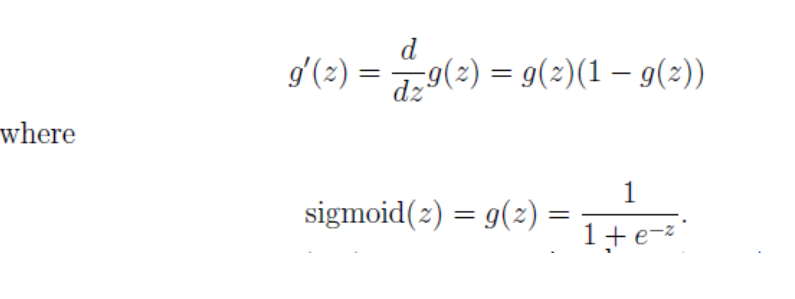

In [8]:
from IPython.display import Image
Image(filename="Datasets/sigmoidgrad.png")

In [9]:
def sigmoidgrad(z):
    return sigmoid(z)*(1-sigmoid(z))

<h4>2. Then we will randomly initialize parameters for symmetry breaking.</h4>

In [10]:
def randominit(layerIn, layerOut):
    epsilon = 0.12
    return np.random.rand(layerOut, layerIn+1) * (2 * epsilon) - epsilon

init_theta1 = randominit(inputLayer, hiddenLayer)
init_theta2 = randominit(hiddenLayer, outputLayer)
init_params = np.hstack((init_theta1.ravel(order='F'), init_theta2.ravel(order='F')))

In [11]:
costfunction(init_params, inputLayer, hiddenLayer, outputLayer, X, y, lmbda)

7.475378110145304

<h4>3. Then we will compute the backpropagation</h4>

In [12]:
def grad(params, inputlayer, hiddenlayer, outputlayer, X, y, lmbda):
    
    theta1 = np.reshape(params[:hiddenlayer*(inputlayer+1)], (hiddenlayer,inputlayer+1), 'F')
    theta2 = np.reshape(params[hiddenlayer*(inputlayer+1):], (outputlayer, hiddenlayer+1),'F')
    y_d = pd.get_dummies(y.flatten())
    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)
    m = len(y)
    
    for i in range(X.shape[0]):
        ones = np.ones(1)
        a1 = np.hstack((ones, X[i]))
        z2 = a1 @ theta1.T
        a2 = np.hstack((ones, sigmoid(z2)))
        z3 = a2 @ theta2.T
        a3 = sigmoid(z3)
        
        d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
        z2 = np.hstack((ones, z2))
        d2 = np.multiply(theta2.T @ d3.T, sigmoidgrad(z2).T[:,np.newaxis])
        delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2 = delta2 + d3.T @ a2[np.newaxis,:]
        
    delta1 /= m
    delta2 /= m 
    
    delta1[:,1:] = delta1[:,1:] + theta1[:,1:] * lmbda/m
    delta2[:,1:] = delta2[:,1:] + theta2[:,1:] * lmbda/m
    
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))

In [13]:
backPropParams = grad(params, inputLayer, hiddenLayer, outputLayer, X, y, 1)

<h3>Using gradient checking to make sure that our backprop algorithm has no bugs and works as intended</h3>

In [14]:
def checkGradient(params, backpropparams, inputlayer, hiddenlayer, outputlayer, X, y, lmbda=0):
    eps = .0001
    flattened = params 
    flattenedDs = backpropparams
    n_elems = len(flattened)
    
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems, 1))
        epsvec[x] = eps
        
        cost_high = costfunction(flattened + epsvec.flatten(), inputlayer, hiddenlayer, outputlayer, X, y, lmbda)
        cost_low = costfunction(flattened - epsvec.flatten(), inputlayer, hiddenlayer, outputlayer, X, y, lmbda)
        grad = (cost_high - cost_low) / float(2*eps)
        print("Element: {0}. Numerical Gradient = {1:.9f}. BackProp Gradient = {2:.9f}.".format(x, grad, flattenedDs[x]))

In [15]:
checkGradient(params, backPropParams, inputLayer, hiddenLayer, outputLayer, X, y, lmbda)

Element: 5164. Numerical Gradient = 0.000080545. BackProp Gradient = 0.000080545.
Element: 8563. Numerical Gradient = -0.000001433. BackProp Gradient = -0.000001433.
Element: 9685. Numerical Gradient = -0.000006230. BackProp Gradient = -0.000006230.
Element: 2249. Numerical Gradient = 0.000192129. BackProp Gradient = 0.000192129.
Element: 8395. Numerical Gradient = 0.000050338. BackProp Gradient = 0.000050338.
Element: 8412. Numerical Gradient = -0.000002016. BackProp Gradient = -0.000002016.
Element: 8987. Numerical Gradient = 0.000001747. BackProp Gradient = 0.000001747.
Element: 5361. Numerical Gradient = -0.000075075. BackProp Gradient = -0.000075075.
Element: 8988. Numerical Gradient = -0.000002440. BackProp Gradient = -0.000002440.
Element: 7648. Numerical Gradient = -0.000043002. BackProp Gradient = -0.000043002.
